Thanks to this discussion for the observation: https://www.kaggle.com/c/santander-customer-transaction-prediction/discussion/84450

In this notebook, I transform this column and re-order the train dataset using this column, and see what 
happens.

In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
train_df = pd.read_csv('../input/train.csv')

# Before you read

This exploration is an attempt to discover some hidden things behind the annonymization.
Nothing is certain of course and this is so far specualative. 
Use this knowledge accordingly. 

# Preliminary work

Two things to observe: 
    
- data has been annonymized
- it comes from a business setting

Thus, it is most likely (but not 100% sure) that some of the features
contain date-like information (and also categorical features but that's 
for another day). 

How to find potential columns? Let's try to sort the columns using the number of unique 
values. What's the heurestic behind this choice? 
Well there shouldn't be a lot of dates, maybe few thousand top.

In [3]:
train_df.drop(['ID_code', 'target'], axis=1).nunique().sort_values()

var_68        451
var_91       7962
var_108      8525
var_103      9376
var_12       9561
var_148     10608
var_161     11071
var_71      13527
var_25      14853
var_43      15188
var_125     16059
var_166     17902
var_169     18242
var_133     19236
var_15      19810
var_131     21464
var_23      24913
var_34      25164
var_93      26708
var_95      29387
var_42      31592
var_50      32308
var_126     32411
var_98      33266
var_53      33460
var_57      35545
var_28      35859
var_130     36638
var_59      37744
var_6       38599
            ...  
var_51     143455
var_118    143667
var_19     144180
var_83     144281
var_137    144397
var_158    144556
var_54     144776
var_82     144829
var_184    145184
var_178    145235
var_30     145977
var_102    146237
var_96     148099
var_149    148504
var_182    149195
var_199    149430
var_100    150727
var_48     152039
var_70     153193
var_47     154781
var_160    156274
var_136    156615
var_187    157031
var_90     157210
var_120   

==> `var_68` has the least number of uniques, thus it **might** be a date-like column
(it could also be a categorical column).
There is also a possibility that this small number of uniques is a coincidence due to the rounding to 4 decimal numbers (bonus question: could you compute the probability of this event?)

In [4]:
f"Min: {train_df['var_68'].min()} and max: {train_df['var_68'].max()}"

'Min: 4.9938 and max: 5.0469'

So how to extract a date?
Well, first, get ride of the decimal values.
Then transform to a datetime object supposing that it is an ordinal datetime.
Try different offsets until you get a meaningful date range.
That's it. Let's see this in action.

In [5]:
epoch_datetime = pd.datetime(1900, 1, 1)
trf_var_68_s = (train_df['var_68']*10000 - 7000 + epoch_datetime.toordinal()).astype(int)
date_s = trf_var_68_s.map(datetime.fromordinal)
train_df['date'] = date_s
sorted_train_df = train_df.drop('var_68', axis=1).sort_values('date')

# Some plots 

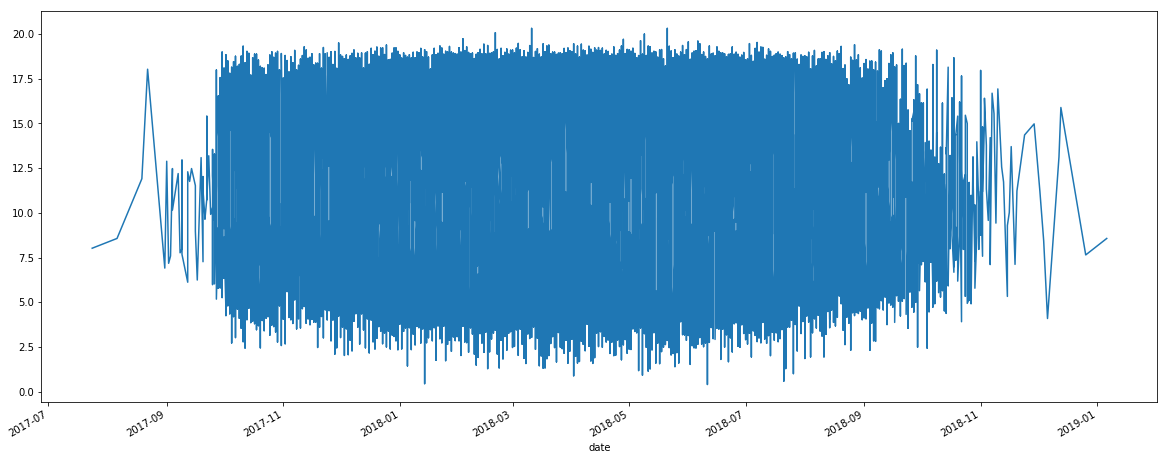

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
sorted_train_df.set_index('date')['var_0'].plot(ax=ax)

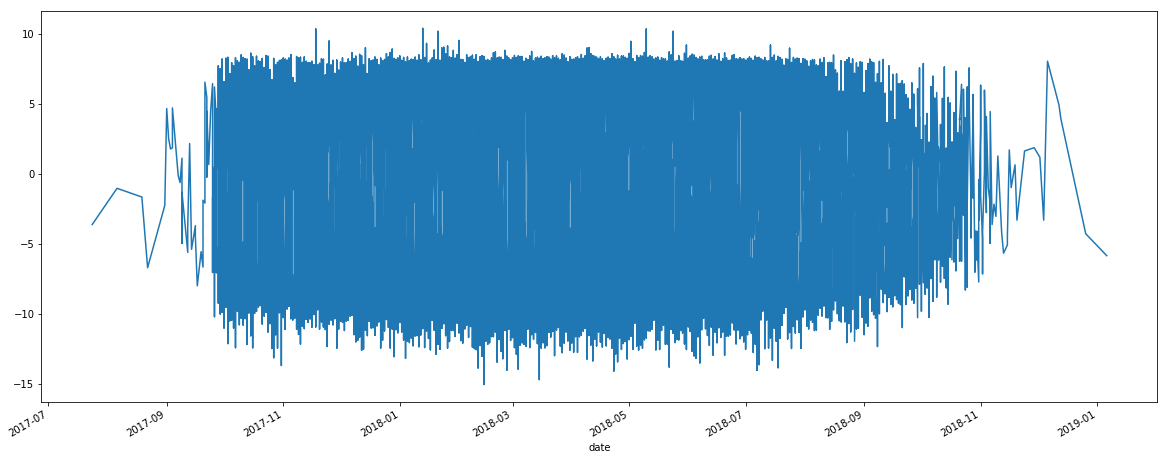

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
sorted_train_df.set_index('date')['var_1'].plot(ax=ax)

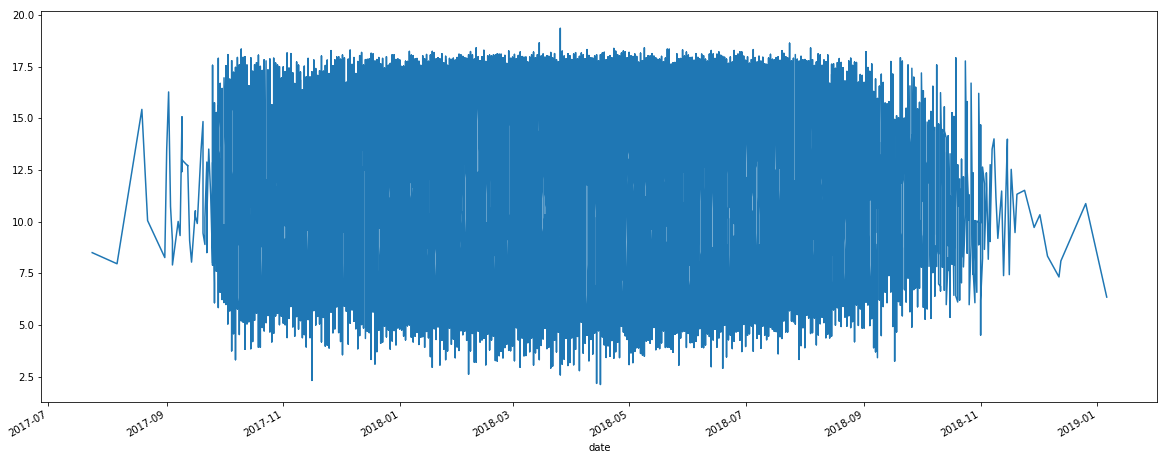

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
sorted_train_df.set_index('date')['var_2'].plot(ax=ax)

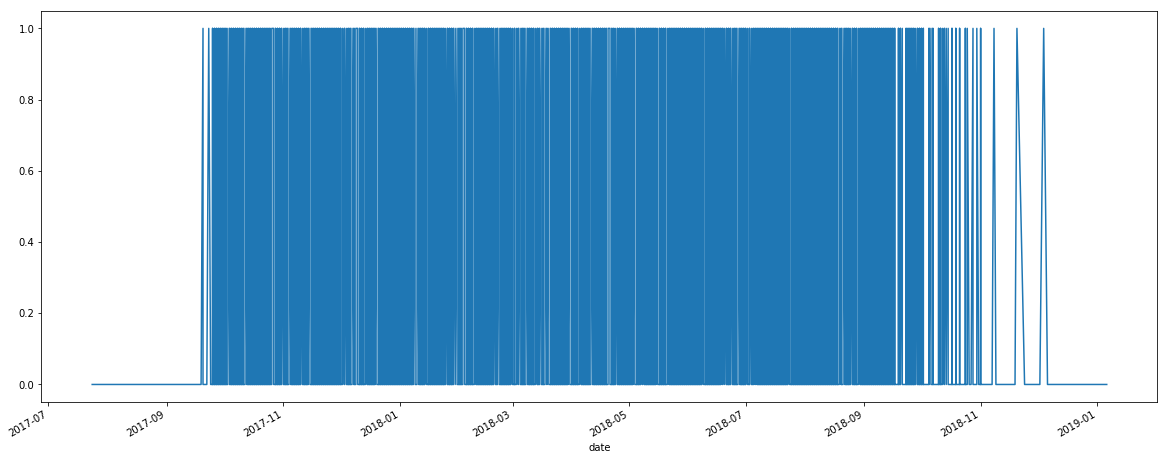

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
sorted_train_df.set_index('date')['target'].plot(ax=ax)

# Date column exploration

Alright, let's now explore this newly created column.

In [10]:
date_s.nunique()

451

=> I will thus use the `date` column to group rows. 

In [11]:
f"Train starts: {date_s.min()}, ends: {date_s.max()}"

'Train starts: 2017-07-24 00:00:00, ends: 2019-01-06 00:00:00'

In [12]:
sorted_train_df['date'].dt.month.value_counts()

4     31061
3     30962
5     29232
2     25644
6     21630
1     19304
7     13026
12    10618
8      5650
11     5613
10     5474
9      1786
Name: date, dtype: int64

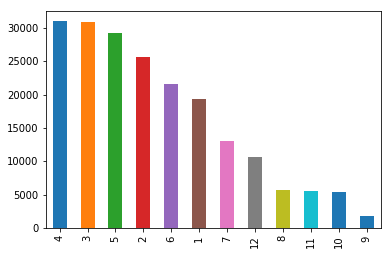

In [13]:
sorted_train_df['date'].dt.month.value_counts().plot(kind='bar')

In [14]:
sorted_train_df['date'].dt.year.value_counts()

2018    178459
2017     21540
2019         1
Name: date, dtype: int64

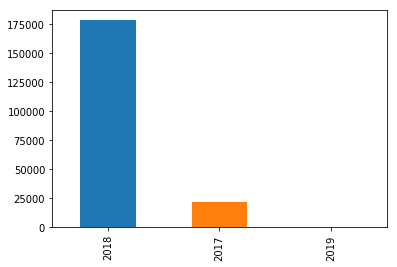

In [15]:
sorted_train_df['date'].dt.year.value_counts().plot(kind='bar')

In [16]:
sorted_train_df['date'].dt.dayofweek.value_counts()

0    28862
5    28709
3    28687
1    28550
4    28477
2    28392
6    28323
Name: date, dtype: int64

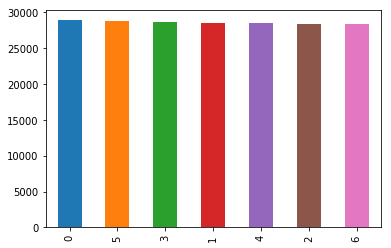

In [17]:
sorted_train_df['date'].dt.dayofweek.value_counts().plot(kind='bar')

==> Uniform day of week distribution. That's a good sign!

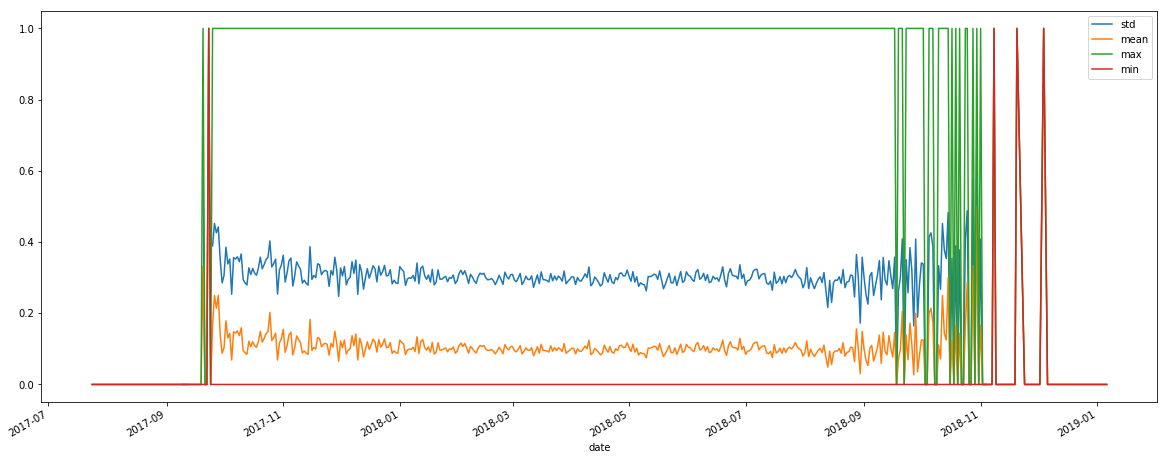

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
sorted_train_df.groupby('date')['target'].agg(['std', 'mean', 'max', 'min']).plot(ax=ax)

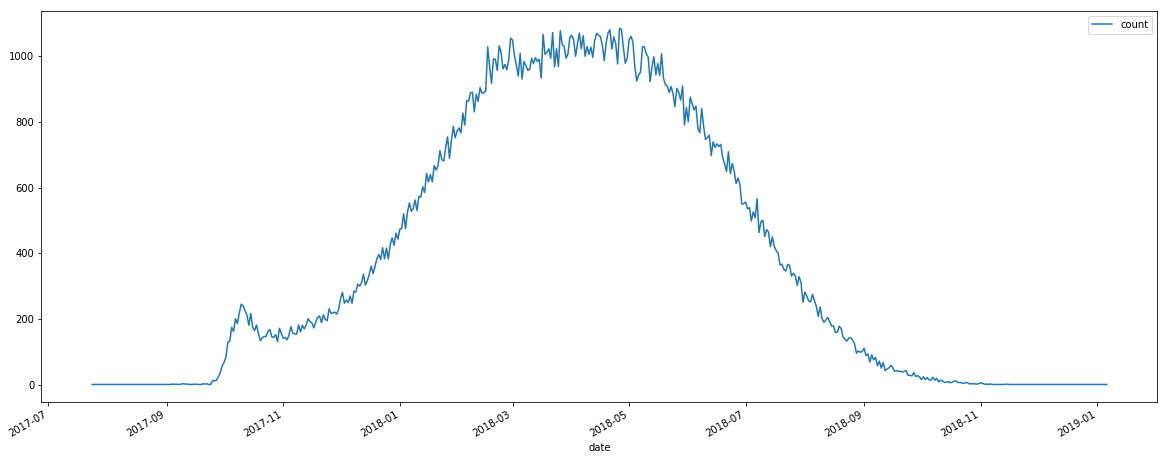

In [19]:
# In another cell signs the count is much bigger than the other statistics
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
sorted_train_df.groupby('date')['target'].agg(['count']).plot(ax=ax)

# What about the test?

Let's see if our observation transfers well to the test dataset.

In [20]:
test_df = pd.read_csv('../input/test.csv')
epoch_datetime = pd.datetime(1900, 1, 1)
s = (test_df['var_68']*10000 - 7000 + epoch_datetime.toordinal()).astype(int)
test_df['date'] = s.map(datetime.fromordinal)
sorted_test_df = test_df.drop('var_68', axis=1).sort_values('date')

In [21]:
f"Test starts: {test_df['date'].min()} and ends: {test_df['date'].max()}"

'Test starts: 2017-08-15 00:00:00 and ends: 2019-01-02 00:00:00'

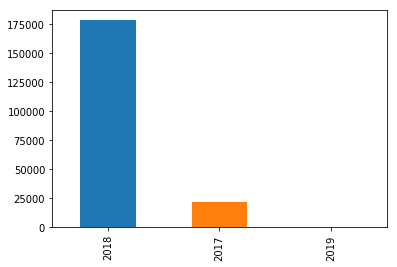

In [22]:
test_df['date'].dt.year.value_counts().plot(kind='bar')

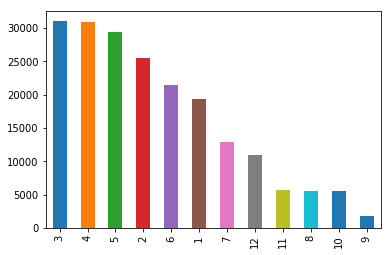

In [23]:
test_df['date'].dt.month.value_counts().plot(kind='bar')

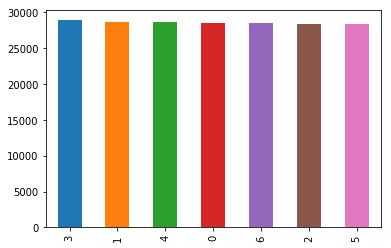

In [24]:
test_df['date'].dt.dayofweek.value_counts().plot(kind='bar')

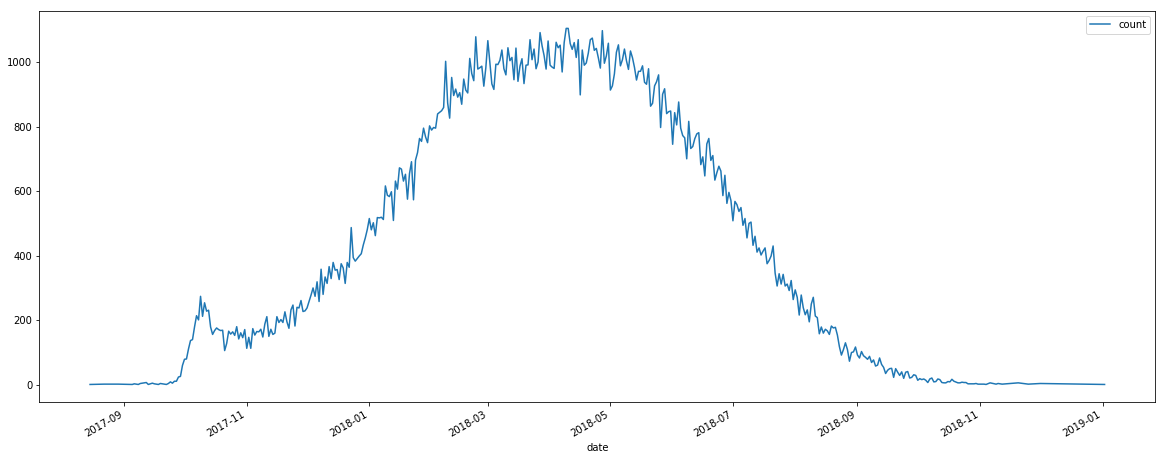

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
sorted_test_df.groupby('date')['var_1'].agg(['count']).plot(ax=ax)

# Test and train date column comparaison

In [26]:
len(set(sorted_train_df['date']))

451

In [27]:
len(set(sorted_test_df['date']))

428

In [28]:
len(set(sorted_train_df['date']) & set(sorted_test_df['date']))

418

In [29]:
len(set(sorted_train_df['date']) - set(sorted_test_df['date']))

33

In [30]:
len(set(sorted_test_df['date']) - set(sorted_train_df['date']))

10

In [31]:
set(sorted_test_df['date']) - set(sorted_train_df['date'])

{Timestamp('2017-08-15 00:00:00'),
 Timestamp('2017-08-29 00:00:00'),
 Timestamp('2017-09-05 00:00:00'),
 Timestamp('2017-09-06 00:00:00'),
 Timestamp('2017-09-15 00:00:00'),
 Timestamp('2017-09-18 00:00:00'),
 Timestamp('2018-11-11 00:00:00'),
 Timestamp('2018-11-25 00:00:00'),
 Timestamp('2018-12-01 00:00:00'),
 Timestamp('2019-01-02 00:00:00')}

==> Most of the dates overlap. 

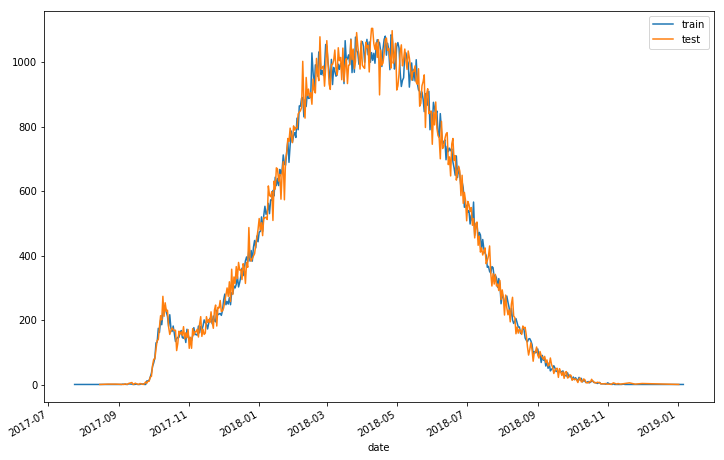

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
sorted_train_df.groupby('date')['var_91'].count().plot(ax=ax, label="train")
sorted_test_df.groupby('date')['var_91'].count().plot(ax=ax, label="test")
ax.legend()

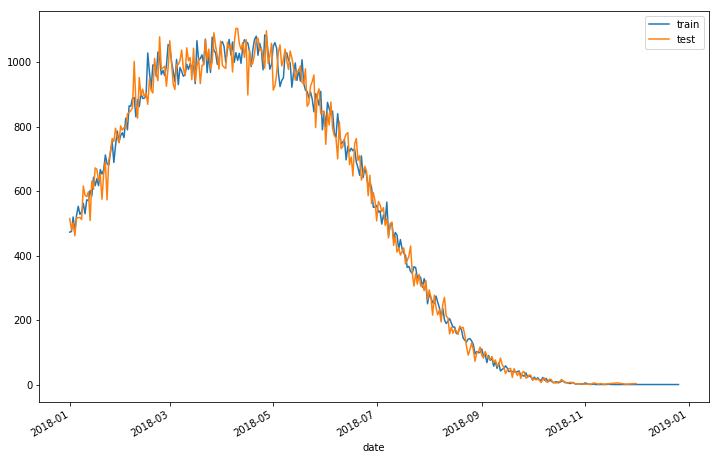

In [33]:
# Zoom on 2018
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
(sorted_train_df.loc[lambda df: df.date.dt.year == 2018]
               .groupby('date')['var_91']
               .count()
               .plot(ax=ax, label="train"))
(sorted_test_df.loc[lambda df: df.date.dt.year == 2018]
               .groupby('date')['var_91']
               .count()
               .plot(ax=ax, label="test"))
ax.legend()

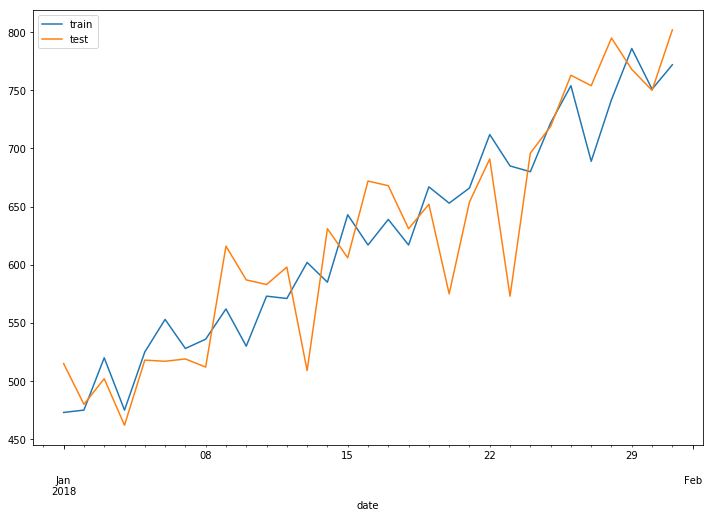

In [34]:
# Zoom on 2018-1
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
(sorted_train_df.loc[lambda df: (df.date.dt.year == 2018) & (df.date.dt.month == 1)]
               .groupby('date')['var_91']
               .count()
               .plot(ax=ax, label="train"))
(sorted_test_df.loc[lambda df: (df.date.dt.year == 2018) & (df.date.dt.month == 1)]
               .groupby('date')['var_91']
               .count()
               .plot(ax=ax, label="test"))
ax.legend()

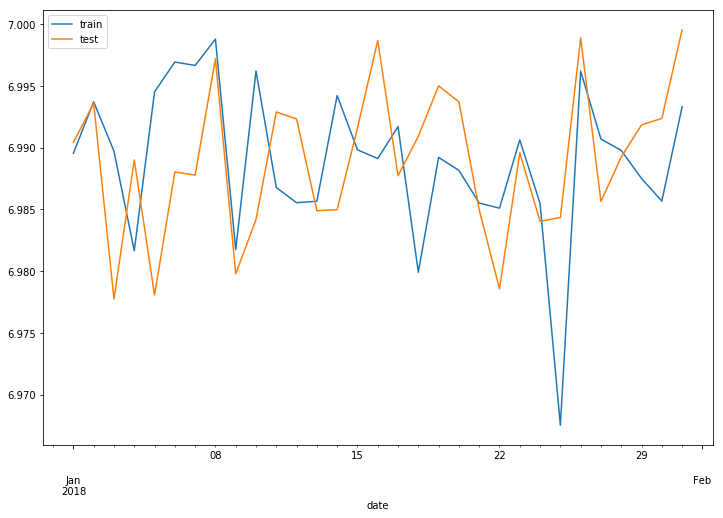

In [35]:
# Zoom on 2018-1
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
(sorted_train_df.loc[lambda df: (df.date.dt.year == 2018) & (df.date.dt.month == 1)]
               .groupby('date')['var_91']
               .mean()
               .plot(ax=ax, label="train"))
(sorted_test_df.loc[lambda df: (df.date.dt.year == 2018) & (df.date.dt.month == 1)]
               .groupby('date')['var_91']
               .mean()
               .plot(ax=ax, label="test"))
ax.legend()

Idea to try: predict the mean of the target (using the date 
for grouping) for the overlapping dates. 

In [36]:
overlapping_dates = set(sorted_train_df['date']) & set(sorted_test_df['date'])

In [37]:
grouped_df = (sorted_train_df.loc[lambda df: df.date.isin(overlapping_dates)]
                             .groupby('date')['target']
                             .mean())

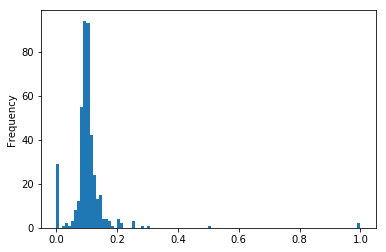

In [38]:
grouped_df.plot(kind='hist', bins=100)

In [39]:
grouped_df.to_csv('grouped_df.csv', index=False)

# What to do now?

Some of the things I will try to do: 
- Use this transformed column for a better temporal CV. Some ideas I have tried: stratification using years, day of weeks, and so on.
- Transform other columns using this new one

Stay tuned for more insights. :)